# Transfer learning example
    - Faces96 dataset download from http://cswww.essex.ac.uk/mv/allfaces/faces96.html
    - Pretrained keras models
    

In [1]:
from __future__ import print_function

#Basic libraries
import numpy as np
import tensorflow as tf
import time
from os import listdir, walk
from os.path import isfile, join
import random

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image


# Select GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


print('Tensorflow version: ', tf.__version__)

data_path = '/home/ubuntu/data/training/image/faces/'


Tensorflow version:  1.4.0


In [2]:
# Data features
categories=[]
labels={}
for dirname, dirnames, filenames in walk(join(data_path,'train')):
    # print path to all subdirectories first.
    for i,subdirname in enumerate(dirnames):
        categories += [subdirname]
        labels[i] = subdirname
print('Categories: ', categories)

n_classes = len(categories)
print('Num classes: ', n_classes)


Categories:  ['carund', 'sdaly', 'agaffa', 'pmathi', 'rchadh', 'spyount', 'wylsow', 'filip', 'kdaska', 'amtalb', 'bcbesta', 'jwdpag', 'dmcdow', 'sherbe', 'dlwise', '9540733', '9540644', 'shamilc', 'nhahme', 'jepott', 'dhaydo', 'idsizm', 'memiah', '9540652', '9540563', '9540709', 'mpdavie', 'pvaris', 'cjhewi', 'gfilip', 'aolcer', 'kelbied', 'mroper', '9540792', 'gdsamp', 'pjburr', 'gmidgl', 'llevet', 'adpoun', 'mkotza', 'csjscu', 'amflem', 'djevan', 'lcelli', 'jphoor', 'jjkeho', 'wardcy', 'dfarre', 'pchyta', 'cowie', 'moshep', '9540725', 'pguan', 'gghazv', 'gmagul', 'swren', 'rposbo', 'mystery', '9540636', 'ireloz', '9540601', '9556273', 'nmakri', '9540814', '9540822', 'gcprie', 'akopci', 'hmgula', 'hwyman', 'icolli', 'pjmcar', 'dnoguy', 'pgray', 'smfarrf', 'jonesd', 'atfpou', 'rbrown', 'mamago', 'jbgood', 'pmbtin', 'pgfost', 'tjpret', '9540512', 'kphans', 'gjbods', 'darodr', 'tthurs', 'cjbowe', 'smredh', '9540768', '9540504', '9540784', 'smalga', 'gllong', 'fmquaz', 'mwilco', 'mclarkd'

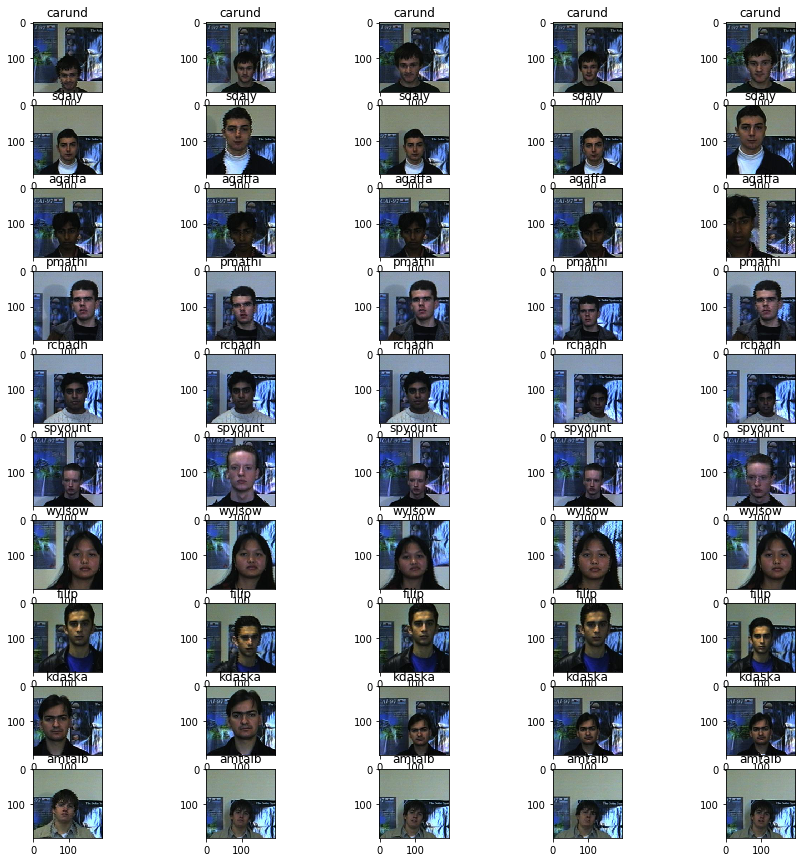

In [3]:
# Examine the images
show_categories = categories
if n_classes>10:
    show_categories = categories[:10]
    
fig = plt.figure()
n=0
for i, category in enumerate(show_categories):
    filelist = [f for f in listdir(join(data_path, 'train', category)) if isfile(join(data_path, 'train', category, f))]
    random.shuffle(filelist) # Randomize images
    for f in filelist[:5]: 
        n += 1
        a = fig.add_subplot(len(show_categories),5,n)
        a.set_title(category)
        img = plt.imread(join(data_path, 'train', category, f))
        plt.imshow(img)
    


## Example: evaluate one image using InceptionV3 imagenet trained model.

Predicted: [('n03595614', 'jersey', 0.59271342), ('n04404412', 'television', 0.040898114), ('n03642806', 'laptop', 0.014330408)]


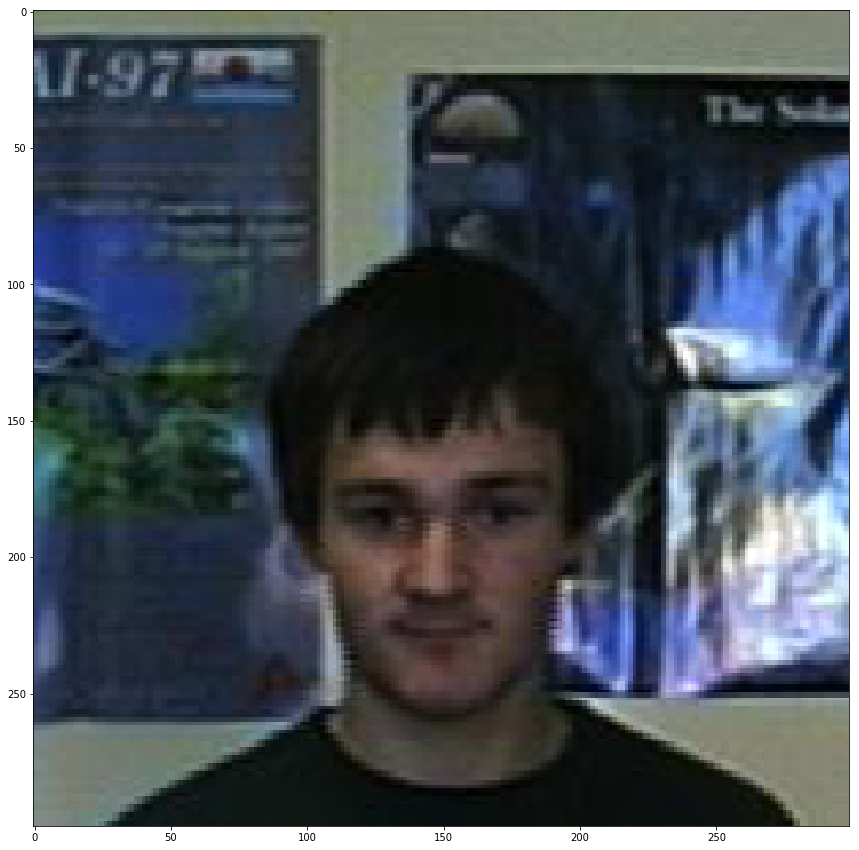

In [6]:
#Load model
model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet')

# Select the path for one image of the selected category
path_category = join(data_path, 'train', categories[0])
img_path = join(path_category, os.listdir(path_category)[0])


# Load image and adapt to 
def load_image(img_path, draw=True, transform=True):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    if transform:
        x = tf.keras.applications.inception_v3.preprocess_input(x)
    if draw:
        plt.imshow(img)
    return x

x = load_image(img_path)
preds = model.predict(x)

# decode the results into a list of tuples (class, description, probability)
print('Predicted:', tf.keras.applications.inception_v3.decode_predictions(preds, top=3)[0])

## Fine tunnig of inceptionV3 for the faces problem



In [8]:
#Load base model
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(299, 299, 3), weights='imagenet', include_top=False)

# Check the output of the last loaded layer
print('Last layer shape:', base_model.output)

Last layer shape: Tensor("mixed10_2/concat:0", shape=(?, 8, 8, 2048), dtype=float32)


In [9]:
# add a global spatial average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
print('New last layer shape:', x)

# Add a fully-connected layer
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
# Add the prediction layer. n_classes
predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)



New last layer shape: Tensor("global_average_pooling2d/Mean:0", shape=(?, 2048), dtype=float32)


In [10]:
# Model to train
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Train only the top layers (which were randomly initialized)
# Freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# Print the summary of the model
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_95 (Conv2D)               (None, 149, 149, 32)  864         input_2[0][0]                    
____________________________________________________________________________________________________
batch_normalization_95 (BatchNor (None, 149, 149, 32)  96          conv2d_95[0][0]                  
____________________________________________________________________________________________________
activation_95 (Activation)       (None, 149, 149, 32)  0           batch_normalization_95[0][0]     
___________________________________________________________________________________________

____________________________________________________________________________________________________
conv2d_114 (Conv2D)              (None, 35, 35, 64)    18432       mixed1[0][0]                     
____________________________________________________________________________________________________
conv2d_116 (Conv2D)              (None, 35, 35, 64)    76800       activation_115[0][0]             
____________________________________________________________________________________________________
conv2d_119 (Conv2D)              (None, 35, 35, 96)    82944       activation_118[0][0]             
____________________________________________________________________________________________________
conv2d_120 (Conv2D)              (None, 35, 35, 64)    18432       average_pooling2d_12[0][0]       
____________________________________________________________________________________________________
batch_normalization_114 (BatchNo (None, 35, 35, 64)    192         conv2d_114[0][0]        

____________________________________________________________________________________________________
activation_180 (Activation)      (None, 8, 8, 320)     0           batch_normalization_180[0][0]    
____________________________________________________________________________________________________
mixed9_1 (Concatenate)           (None, 8, 8, 768)     0           activation_182[0][0]             
                                                                   activation_183[0][0]             
____________________________________________________________________________________________________
concatenate_4 (Concatenate)      (None, 8, 8, 768)     0           activation_186[0][0]             
                                                                   activation_187[0][0]             
____________________________________________________________________________________________________
activation_188 (Activation)      (None, 8, 8, 192)     0           batch_normalization_188[

In [11]:
# Load images 
X_all = []
y_all = []
for i,c in enumerate(categories):
    for f in os.listdir(os.path.join(data_path,'train',c)):
        X_all += list(load_image(os.path.join(data_path,'train',c, f), draw=False))
        y_all += [i]
X_all = np.array(X_all)
y_all = np.array(y_all)

print(X_all.shape, y_all.shape)

(2717, 299, 299, 3) (2717,)


In [12]:
# Separate train and valid datasets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, train_size=0.7, random_state=42)

print(X_train.shape, X_valid.shape)
print(y_train.shape, y_valid.shape)


/home/jorge/anaconda3/envs/tf14/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(1901, 299, 299, 3) (816, 299, 299, 3)
(1901,) (816,)


In [13]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True)
    


In [ ]:
batch_size = 32
train_size = X_train.shape[0]

# Select optimizer and compile model
opt = tf.keras.optimizers.RMSprop(lr=1E-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train
tb_callback_ln = tf.keras.callbacks.TensorBoard(log_dir='/tmp/tensorboard/faces/inception')
history1 = model.fit_generator(datagen.flow(X_train, y_train),
                steps_per_epoch = train_size // batch_size,
                epochs = 30,
                validation_data = (X_valid, y_valid),
                callbacks=[tb_callback_ln])


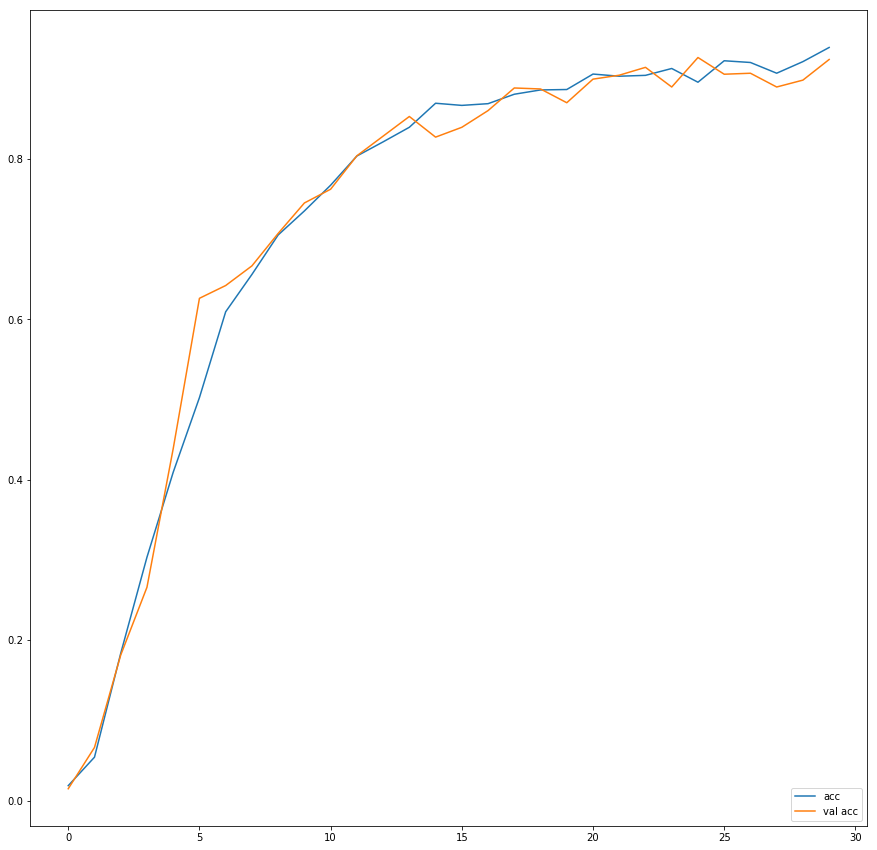

In [20]:
plt.plot(history1.history['acc'], label='acc')
plt.plot(history1.history['val_acc'], label='val acc')
plt.legend(loc='lower right')
plt.show()

Fists inception cell output shape:  (1, 35, 35, 256)


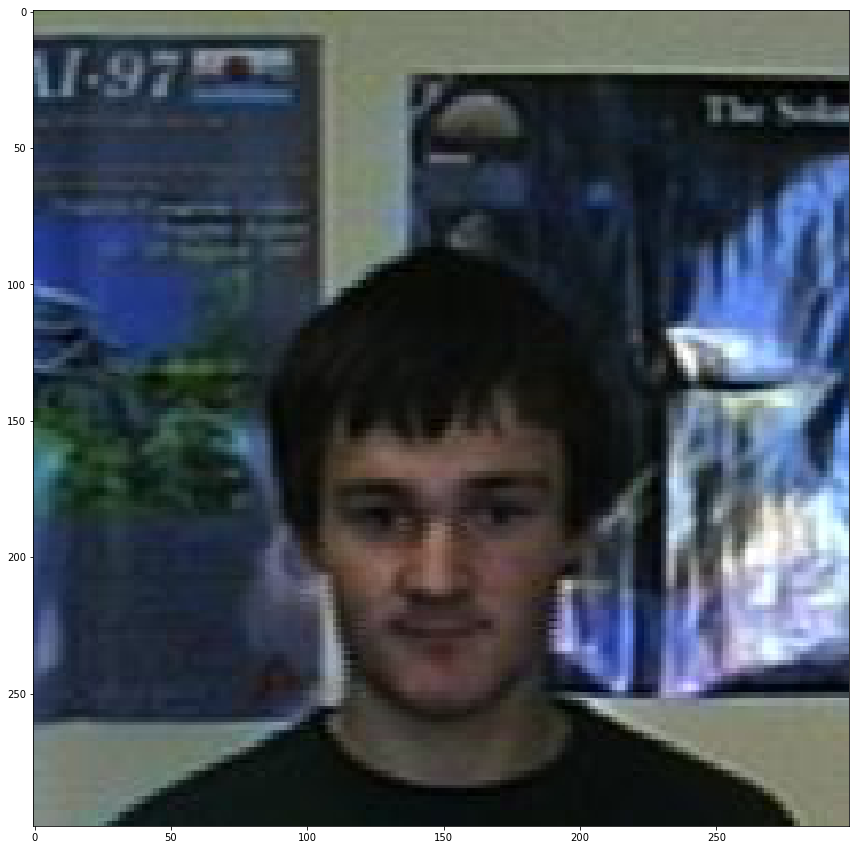

In [16]:
# Print the transformations of the first inception cell: mixed0
model2 = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.get_layer('mixed0').output)

# Read image img
my_filelist = [f for f in listdir(join(data_path, 'train', categories[0])) if isfile(join(data_path, 'train', categories[0], f))]
img_path = join(data_path, 'train', categories[0], my_filelist[0])
img = load_image(img_path)
x = tf.keras.applications.inception_v3.preprocess_input(img)

mixed0_features = model2.predict(x)

print('Fists inception cell output shape: ', mixed0_features.shape)

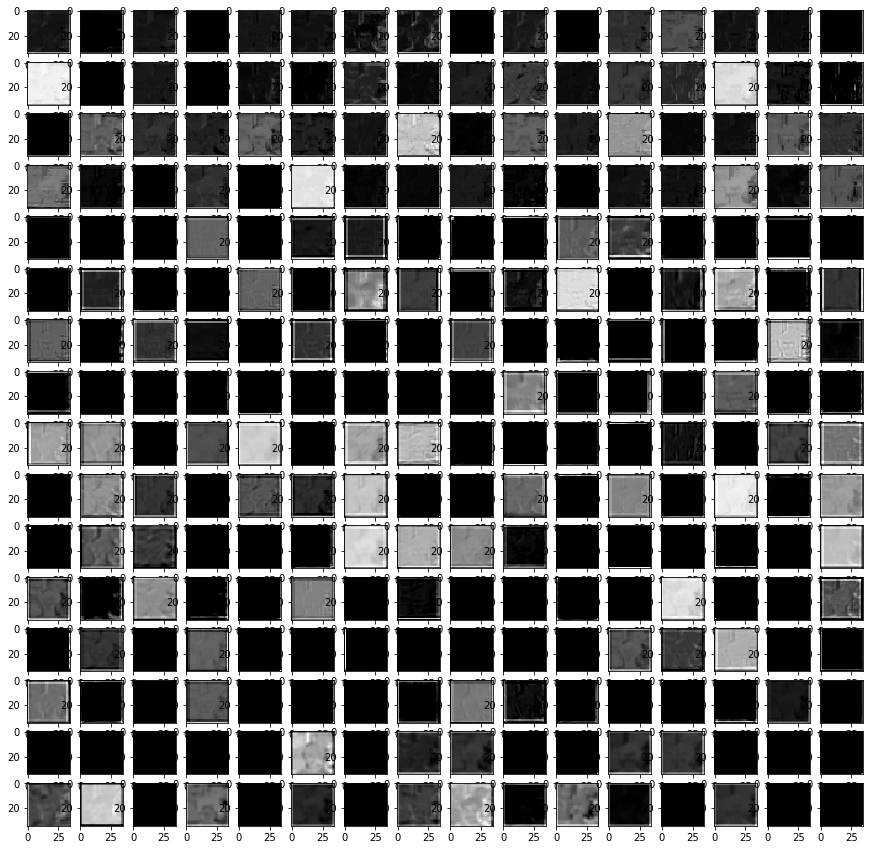

In [23]:
plt.rcParams['figure.figsize'] = (15, 15)        # size of images
plt.rcParams['image.cmap'] = 'gray'              # use grayscale 
fig = plt.figure()
n=0
for i in range(256): #Print the first 100 outputs of the 256.
    n += 1
    a = fig.add_subplot(16,16,n)
    plt.imshow(mixed0_features[0,:,:,i])


In [24]:
#Example of code to extract the first convolutional weights
conv2d_1_w = model2.get_layer(base_model.layers[1].name).get_weights()[0]
conv2d_1_w.shape

(3, 3, 3, 32)

# Fine tuning of the last layers
    - We will freeze the bottom N layers and train the remaining top layers.

In [25]:
# List layer names to see how many layers we will freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [26]:
# we chose to train the top 2 inception blocks, from the mixed8 layer to the last layer
# Then, freeze the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True



In [19]:
# Recompile the model for these modifications to take effect
# Use a low learning rate
opt = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model again (to fine-tuning the top 2 inception blocks and the dense layers
history2 = model.fit_generator(datagen.flow(X_train, y_train),
            steps_per_epoch = train_size // batch_size,
            epochs = 30,
            validation_data = (X_valid, y_valid),
            callbacks=[tb_callback_ln])



Epoch 1/30
59/59 [==============================] - 33s - loss: 0.1691 - acc: 0.9560 - val_loss: 0.2274 - val_acc: 0.9363
Epoch 2/30
59/59 [==============================] - 28s - loss: 0.1480 - acc: 0.9659 - val_loss: 0.2080 - val_acc: 0.9400
Epoch 3/30
59/59 [==============================] - 28s - loss: 0.1352 - acc: 0.9634 - val_loss: 0.1915 - val_acc: 0.9449
Epoch 4/30
59/59 [==============================] - 29s - loss: 0.1191 - acc: 0.9709 - val_loss: 0.1766 - val_acc: 0.9473
Epoch 5/30
59/59 [==============================] - 29s - loss: 0.1212 - acc: 0.9680 - val_loss: 0.1679 - val_acc: 0.9498
Epoch 6/30
59/59 [==============================] - 28s - loss: 0.0999 - acc: 0.9738 - val_loss: 0.1626 - val_acc: 0.9522
Epoch 7/30
59/59 [==============================] - 29s - loss: 0.0973 - acc: 0.9772 - val_loss: 0.1567 - val_acc: 0.9547
Epoch 8/30
59/59 [==============================] - 28s - loss: 0.0947 - acc: 0.9780 - val_loss: 0.1536 - val_acc: 0.9547
Epoch 9/30
59/59 [======

## Evaluate the test data

In [20]:
test_filelist = [f for f in listdir(join(data_path, 'test')) if isfile(join(data_path, 'test', f))]
len(test_filelist)

299

In [21]:
image_array = []
real_test = []
for f in test_filelist:
    real_test += [f.split('.')[0]]
    img_path = join(data_path, 'test', f)
    img = load_image(img_path, draw=False)
    image_array += list(img)
    
probability_test = model.predict(np.array(image_array))
probability_test.shape


(299, 151)

In [22]:
real_test

['dmcdow',
 'sherbe',
 'amtalb',
 'reaton',
 'adpoun',
 'dlwise',
 'gmidgl',
 'rjobyr',
 'wardcy',
 'cowie',
 'djevan',
 'smfarrf',
 'jjohns',
 '9540687',
 'jonesd',
 'mdcowl',
 'gjbods',
 '9540792',
 'gllong',
 'gmidgl',
 'kdaska',
 'pwest',
 '9540725',
 '9540814',
 'wylsow',
 '9540822',
 '9540822',
 '9540709',
 '9556273',
 'ihopki',
 'shamilc',
 'azavro',
 'nhahme',
 'oegill',
 'dfarre',
 'pjburr',
 'jedphi',
 'dlwise',
 'filip',
 'swren',
 'atfpou',
 'jlrums',
 'nhotoo',
 '9540547',
 '9540768',
 'cprice',
 'gpreec',
 '9540644',
 '9540512',
 'bmphil',
 'lcelli',
 'nandri',
 'cjhewi',
 'jjkeho',
 'mpdavie',
 'djpben',
 '9540849',
 '9540784',
 'ireloz',
 'mkvwon',
 'nmakri',
 'gpreec',
 'jepott',
 '9540504',
 'ldebna',
 'darodr',
 'gfilip',
 '9630643',
 '9540741',
 'jjkeho',
 'mpdavie',
 'pmspry',
 'agaffa',
 'tchand',
 '9540644',
 'wardcy',
 'arwebb',
 'dnoguy',
 'rscoop',
 'tthurs',
 'jjohns',
 '9540601',
 'rchadh',
 'jcgrij',
 'rwsick',
 'moshep',
 '9540717',
 '9540636',
 'mystery',

In [24]:
print(len(real_test))
predict_test = [labels[np.argmax(p)] for p in probability_test ]
print(len(predict_test))

299
299


Pct error:  0.013377926421404682


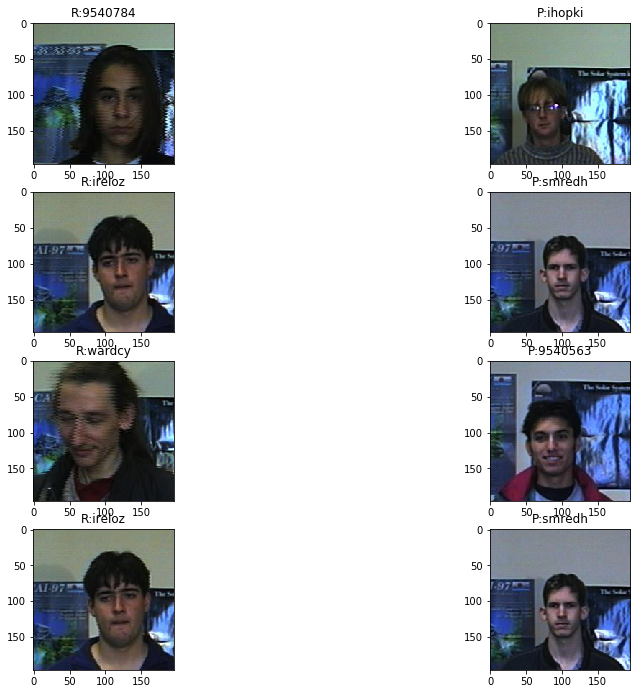

In [25]:
# Print errors
errors_index=[]
for i in range(len(real_test)):
    if real_test[i]!=predict_test[i]:
        errors_index += [i]
    
print('Pct error: ', len(errors_index)/len(predict_test))

fig = plt.figure()
n=0
for i in errors_index[:5]: 
    n += 1
    a = fig.add_subplot(5, 2, n)
    img_path = join(data_path, 'test', test_filelist[i])
    a.set_title('R:' + real_test[i])
    plt.imshow(plt.imread(img_path))

    n += 1
    a = fig.add_subplot(5, 2, n)
    img_path = join(data_path, 'train', predict_test[i], predict_test[i]+'.1.jpg')
    a.set_title('P:' + predict_test[i])
    plt.imshow(plt.imread(img_path))
